# Analysis of Cleaning Procedures

## Prerequisites

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import Dataset
from dataset_constants import *

from collections import Counter

RANDOM_SEED = 0

In [3]:
# Run when dataset.py has been updated

import importlib
import dataset
importlib.reload(dataset) # reload to update changes to the file
from dataset import Dataset

## Helper Functions

In [6]:
def plot_hate_freq(train_df, val_df, test_df):
    # Count occurrences of 0s and 1s for each set
    train_counts = train_df['label'].value_counts()
    validation_counts = val_df['label'].value_counts()
    test_counts = test_df['label'].value_counts()

    # Ensure both labels (0 and 1) exist in each set, even if they are zero
    train_counts = train_counts.reindex([0, 1], fill_value=0)
    validation_counts = validation_counts.reindex([0, 1], fill_value=0)
    test_counts = test_counts.reindex([0, 1], fill_value=0)

    # Calculate total counts for percentages
    train_total = train_counts.sum()
    val_total = validation_counts.sum()
    test_total = test_counts.sum()

    # Calculate percentages
    train_percent = train_counts / train_total * 100
    val_percent = validation_counts / val_total * 100
    test_percent = test_counts / test_total * 100

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.3  # Adjusted width of the bars to reduce spacing

    # Positions for bars
    train_positions = np.arange(len(train_counts))
    val_positions = np.arange(len(validation_counts)) + bar_width * 2
    test_positions = np.arange(len(test_counts)) + bar_width * 4

    # Plot stacked bars
    train_bars_not_hate = ax.bar(train_positions[0], train_counts[0], bar_width, label='Not Hate Speech', color='tab:blue')
    train_bars_hate = ax.bar(train_positions[0], train_counts[1], bar_width, bottom=train_counts[0], label='Hate Speech', color='tab:orange')

    val_bars_not_hate = ax.bar(val_positions[0], validation_counts[0], bar_width, label='Not Hate Speech', color='tab:blue')
    val_bars_hate = ax.bar(val_positions[0], validation_counts[1], bar_width, bottom=validation_counts[0], label='Hate Speech', color='tab:orange')

    test_bars_not_hate = ax.bar(test_positions[0], test_counts[0], bar_width, label='Not Hate Speech', color='tab:blue')
    test_bars_hate = ax.bar(test_positions[0], test_counts[1], bar_width, bottom=test_counts[0], label='Hate Speech', color='tab:orange')

    # Add labels, title, and legend
    ax.set_ylabel('Count')
    ax.set_title('Count of Hate Speech Labels by Dataset')

    # Create a custom legend with unique labels
    handles, labels = ax.get_legend_handles_labels()
    unique_handles = [handles[0], handles[1]]  # Select unique handles
    unique_labels = ['Not Hate Speech', 'Hate Speech']

    ax.legend(unique_handles, unique_labels)

    # Function to add labels and percentages on the bars
    def add_labels_and_percentages(bars, counts, percentages):
        for bar, count, percentage in zip(bars, counts, percentages):
            height = bar.get_height()
            if height > 0:
                x_pos = bar.get_x() + bar.get_width() / 2
                y_pos = bar.get_y() + height / 2
                ax.annotate(f'{count}\n({percentage:.1f}%)',
                            xy=(x_pos, y_pos),
                            xytext=(0, 5),
                            textcoords="offset points",
                            ha='center', va='center', color='white')

    # Add labels and percentages to "Not Hate Speech" and "Hate Speech" bars separately
    add_labels_and_percentages(train_bars_not_hate, [train_counts[0]], [train_percent[0]])
    add_labels_and_percentages(train_bars_hate, [train_counts[1]], [train_percent[1]])

    add_labels_and_percentages(val_bars_not_hate, [validation_counts[0]], [val_percent[0]])
    add_labels_and_percentages(val_bars_hate, [validation_counts[1]], [val_percent[1]])

    add_labels_and_percentages(test_bars_not_hate, [test_counts[0]], [test_percent[0]])
    add_labels_and_percentages(test_bars_hate, [test_counts[1]], [test_percent[1]])

    plt.tight_layout()
    plt.show()

## Original Uncleaned Data

In [7]:
dataset_uncleaned = Dataset(train_path=TRAIN_DATASET_PATH,
                  val_path=VALIDATION_DATASET_PATH, 
                  test_path=TEST_DATASET_PATH)
dataset_uncleaned.build()

X_train_uncleaned = dataset_uncleaned.get_features(split_type="train")
Y_train_uncleaned = dataset_uncleaned.get_labels(split_type="train")
X_val_uncleaned = dataset_uncleaned.get_features(split_type="val")
Y_val_uncleaned = dataset_uncleaned.get_labels(split_type="val")
X_test_uncleaned = dataset_uncleaned.get_features(split_type="test")
Y_test_uncleaned = dataset_uncleaned.get_labels(split_type="test")
X_uncleaned = dataset_uncleaned.get_features()
Y_uncleaned = dataset_uncleaned.get_labels()

In [8]:
len(X_uncleaned)

18464

In [88]:
import re

def count_texts(texts, pattern):
    count = 0
    matched_tweets = []

    # Iterate through each text and check for the presence of the pattern
    for text in texts:
        if re.search(pattern, text):
            count += 1
            matched_tweets.append(text)
    
    return matched_tweets, count

In [117]:
# search for emoticons
matches, count = count_texts(X_uncleaned,r':\)+|:\(+')
print(count) # only 1% of the tweets have emoticons. can ignore to simplify analysis

198


# Part I. Cleaned Dataset with Duplicates

The following preprocessing was performed:
- Removed URLs and usernames
- Removed numeric words
- Convert all text to lowercase
- Removed 'rt'
- Expanded contractions
- Removed punctuations
- Removed stopwords

In [20]:
dataset_v0 = Dataset(full_data_path='cleaned_dataset_v0.pkl',
                  from_scratch=False,
                  split_sizes=[10000, 4232, 4232])
dataset_v0.build()

X_train = dataset_v0.get_features(split_type="train")
Y_train = dataset_v0.get_labels(split_type="train")
X_val = dataset_v0.get_features(split_type="val")
Y_val = dataset_v0.get_labels(split_type="val")
X_test = dataset_v0.get_features(split_type="test")
Y_test = dataset_v0.get_labels(split_type="test")

Data loaded from cleaned_dataset_v0.pkl


In [4]:
# Convert to pandas df
train_df = pd.DataFrame(
    {'tweets': X_train,
     'label': Y_train
    })

val_df = pd.DataFrame(
    {'tweets': X_val,
     'label': Y_val
    })

test_df = pd.DataFrame(
    {'tweets': X_test,
     'label': Y_test
    })

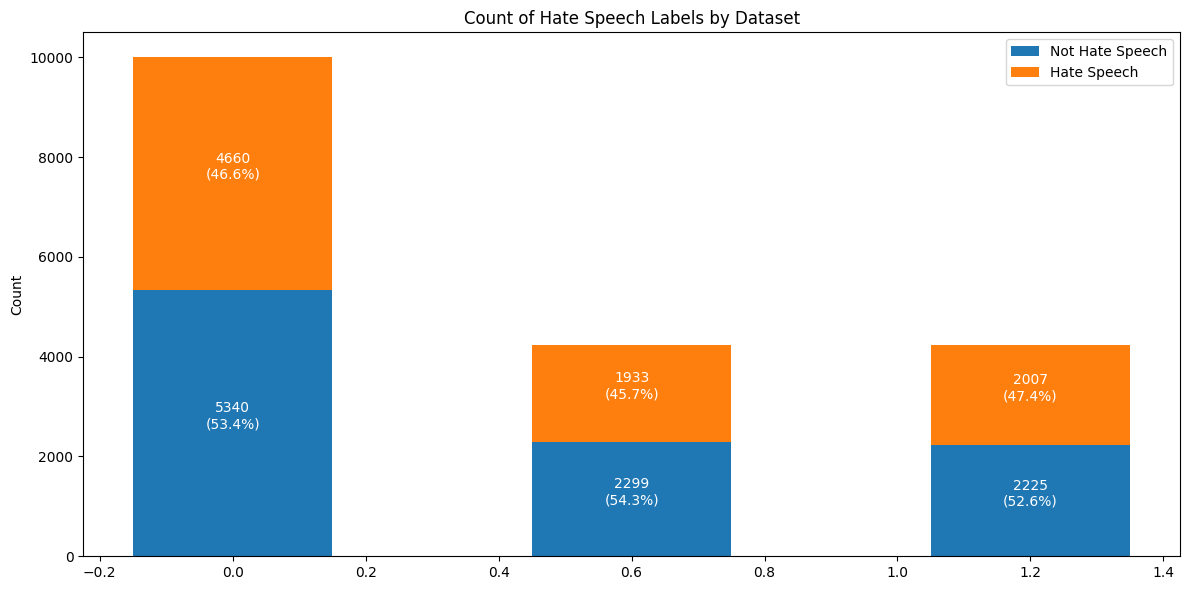

In [9]:
plot_hate_freq(train_df,val_df,test_df)

## Analysis of Duplicates

In [10]:
# Count the occurrences in each set
train_counts = Counter(X_train)
val_counts = Counter(X_val)
test_counts = Counter(X_test)

# Create a DataFrame
df_train = pd.DataFrame(train_counts.items(), columns=['Tweet', 'Train_Count'])
df_val = pd.DataFrame(val_counts.items(), columns=['Tweet', 'Val_Count'])
df_test = pd.DataFrame(test_counts.items(), columns=['Tweet', 'Test_Count'])

# Merge DataFrames on 'Tweet'
df = pd.merge(df_train, df_val, on='Tweet', how='outer')
df = pd.merge(df, df_test, on='Tweet', how='outer')

# Fill NaN values with 0 (in case some tweets are missing in some sets)
df = df.fillna(0).astype({'Train_Count': 'int', 'Val_Count': 'int', 'Test_Count': 'int'})

# Calculate total count across train, val, and test
df['Total_Count'] = df['Train_Count'] + df['Val_Count'] + df['Test_Count']

# Filter out rows where the total count is 1 or 0
df_filtered = df[df['Total_Count'] > 1]

# Display the filtered DataFrame
df_filtered.head()

,Tweet,Train_Count,Val_Count,Test_Count,Total_Count
0,,13,8,2,23
20,2nd mar roxas,1,1,1,3
42,4p tinuligsa kampo vp binay tinuligsa kampo vi...,1,1,0,2
99,abigail binay claims peña shut district office...,1,0,1,2
100,abigail binay derpcon secondchancefor charlhon...,2,0,0,2


In [24]:
df_filtered.sort_values(by='Test_Count', ascending=False)

,Tweet,Train_Count,Val_Count,Test_Count,Total_Count
1238,binay,46,26,20,92
8417,mar roxas,33,7,17,57
15287,toni katangian kayong big winner binay nognog ...,6,5,6,17
6476,inang bayan,3,3,5,11
13014,really happened alfred romualdez mar roxas yol...,3,1,5,9
...,...,...,...,...,...
6304,hoy roxas mag fusion poe parang vegetta goku m...,2,0,0,2
6222,honasan belies crowd sinulog booed binay,3,0,0,3
6048,hay nako mar roxas,2,0,0,2
6002,hassle talaga patalastas binay mayorship rin m...,2,0,0,2


In [25]:
print(df_filtered['Total_Count'].sum())

2257


## Part II. Cleaned Dataset with Duplicates Removed

In [4]:
dataset_v1 = Dataset(full_data_path='cleaned_dataset_v1.pkl',
                  from_scratch=False,
                  split_sizes=[8993, 3957, 4099])
dataset_v1.build()

X_train = dataset_v1.get_features(split_type="train")
Y_train = dataset_v1.get_labels(split_type="train")
X_val = dataset_v1.get_features(split_type="val")
Y_val = dataset_v1.get_labels(split_type="val")
X_test = dataset_v1.get_features(split_type="test")
Y_test = dataset_v1.get_labels(split_type="test")

Data loaded from cleaned_dataset_v1.pkl


In [5]:
# Convert to pandas df
train_df = pd.DataFrame(
    {'tweets': X_train,
     'label': Y_train
    })

val_df = pd.DataFrame(
    {'tweets': X_val,
     'label': Y_val
    })

test_df = pd.DataFrame(
    {'tweets': X_test,
     'label': Y_test
    })

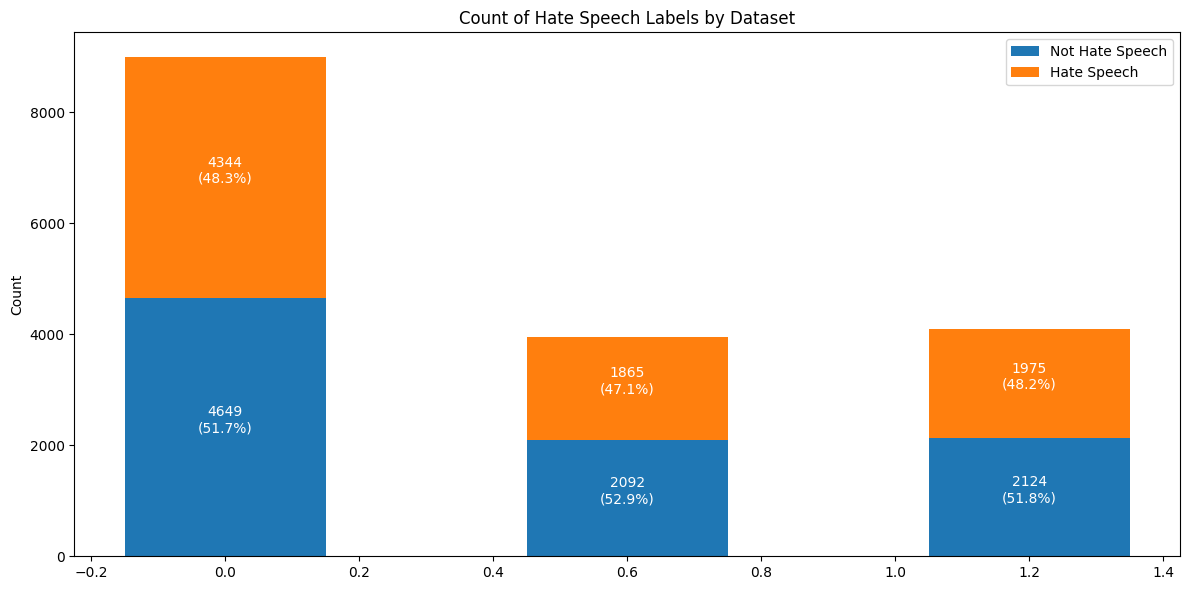

In [7]:
plot_hate_freq(train_df,val_df,test_df)

Proportion of hate tweets in the train val and test sets were not significantly altered by removing duplicates.